In [ ]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='', project_access_token='')
pc = project.project_context


# MARATONA BEHIND THE CODE 2020

## DESAFIO 6 - LIT

<hr>

## Installing Libs

In [ ]:
!pip install scikit-learn --upgrade

In [ ]:
!pip install xgboost==0.71 --upgrade

In [ ]:
!pip install imblearn --upgrade

<hr>

## Download dos conjuntos de dados em formato .csv

In [ ]:
import pandas as pd
import numpy as np

# "SimpleImputer" é uma transformação para preencher valores faltantes em conjuntos de dados
from sklearn.impute import SimpleImputer

# Método para separação de conjunto de dados em amostras de treino e teste
from sklearn.model_selection import train_test_split

# Método para criação de modelos baseados en arvore de decisão
from sklearn.tree import DecisionTreeClassifier

# Método para construção de modelo baseado na técnica Gradient Boosting
from xgboost import XGBClassifier

# Método para criação de modelos baseados na técnica KNN
from sklearn.neighbors import KNeighborsClassifier

# Método para criação de modelos baseados na técnica Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Método para técnicas de avaliação do modelo treinado
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Métodos para balanceamento de classes
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

In [ ]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset-3/master/training_dataset.csv
df_training_dataset = pd.read_csv(r'training_dataset.csv')
df_training_dataset.tail()

Sobre o arquivo "training_dataset.csv", temos algumas informações gerais sobre os usuários da plataforma:

**id**

**graduacao**

**universidade**

**profissao**

**organizacao**

**pretende_fazer_cursos_lit**

**interesse_mba_lit**

**importante_ter_certificado**

**horas_semanais_estudo**

**como_conheceu_lit**

**total_modulos**

**modulos_iniciados**

**modulos_finalizados**

**certificados**

**categoria**

In [ ]:
df_training_dataset.info()

In [ ]:
df_training_dataset.nunique()

In [ ]:
df_training_dataset.describe()

# Analisando os dados

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

## Nível de formação e profissão dos usuários da plataforma

In [ ]:
f, axes = plt.subplots(nrows=5, ncols=1, figsize=(30,30))

sns.countplot(x="graduacao", data=df_training_dataset, ax=axes[0])
sns.countplot(x="universidade", data=df_training_dataset, ax=axes[1])
sns.countplot(x="profissao", data=df_training_dataset, ax=axes[2])
sns.countplot(x="organizacao", data=df_training_dataset, ax=axes[3])
sns.countplot(x="como_conheceu_lit", data=df_training_dataset, ax=axes[4])

## Analisando o balanceamento das classes

In [ ]:
f, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,5))

sns.countplot(x="categoria", data=df_training_dataset)

## Mapa de correlação entre as variaveis

In [ ]:
#Selecionando features númericas
df = df_training_dataset.iloc[:, 5:15]
df = df.drop(columns=["como_conheceu_lit"])
#Replace NaN values por 0
df.fillna(0, inplace=True)

f, axes = plt.subplots(figsize=(15,5))

sns.heatmap(data=df.corr(), annot=True, vmin=-1, vmax=1, center=0)

## Analise dos alunos por perfil

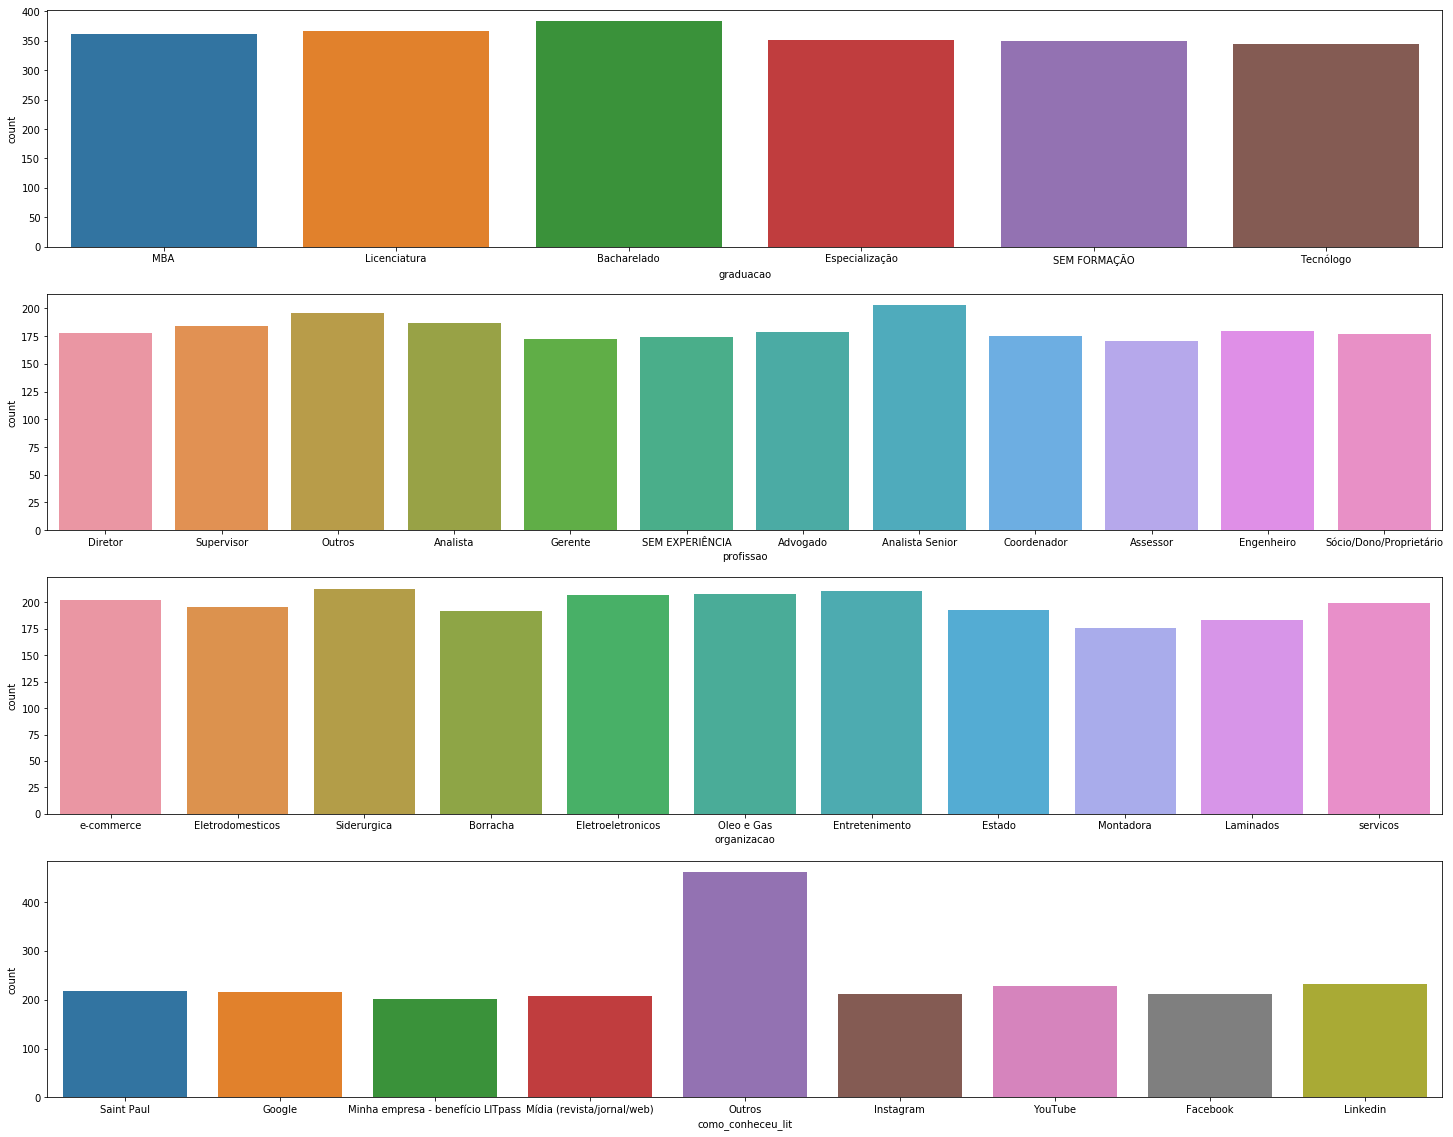

In [ ]:
criteria = "perfil1"

f, axes = plt.subplots(nrows=4, ncols=1, figsize=(25,20))

df = df_training_dataset[df_training_dataset["categoria"]==criteria]

sns.countplot(x="graduacao", data=df, ax=axes[0])
sns.countplot(x="profissao", data=df, ax=axes[1])
sns.countplot(x="organizacao", data=df, ax=axes[2])
sns.countplot(x="como_conheceu_lit", data=df, ax=axes[3])

## Analisando os outliers

In [ ]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(25,30))

sns.boxplot(x="categoria", y="horas_semanais_estudo", data=df_training_dataset, ax=axes[0,0])
sns.boxplot(x="categoria", y="total_modulos", data=df_training_dataset, ax=axes[0,1])
sns.boxplot(x="categoria", y="modulos_iniciados", data=df_training_dataset, ax=axes[1,0])
sns.boxplot(x="categoria", y="modulos_finalizados", data=df_training_dataset, ax=axes[1,1])
sns.boxplot(x="categoria", y="certificados", data=df_training_dataset, ax=axes[2,0])

In [ ]:
feature_name = "modulos_finalizados"

 # Primeiro quartil - representa 25% dos dados
Q1 = df_training_dataset[feature_name].quantile(0.25)
# Terceiro quartil - representa 75% dos dados
Q3 = df_training_dataset[feature_name].quantile(0.75)
#Intervalo inter-quartil (Q3-Q1)
IQR = Q3 - Q1
# Limite máximo
max_lim = Q3 + 1.5 * IQR
# Limite mínimo
min_lim = Q1 - 1.5 * IQR

df = df_training_dataset[df_training_dataset[feature_name] > max_lim]

f, axes = plt.subplots(nrows=3, ncols=1, figsize=(20,20))

sns.countplot(x="categoria", data=df, ax=axes[0])
sns.countplot(x="graduacao", data=df, ax=axes[1])
sns.countplot(x="profissao", data=df, ax=axes[2])

## Analisando variaveis binárias

In [ ]:
feature_name = "pretende_fazer_cursos_lit"
criteria = 0

df = df_training_dataset[df_training_dataset[feature_name] == criteria]

f, axes = plt.subplots(nrows=3, ncols=1, figsize=(20,20))

sns.countplot(x="categoria", data=df, ax=axes[0])
sns.countplot(x="graduacao", data=df, ax=axes[1])
sns.countplot(x="profissao", data=df, ax=axes[2])

<hr>

## Detalhamento do desafio: classificação multiclasse

Este é um desafio cujo objetivo de negócio é a segmentação dos usuários de uma plataforma de ensino. Para tal, podemos utilizar duas abordagens: aprendizado de máquina supervisionado (classificação) ou não-supervisionado (clustering). Neste desafio será aplicada a classificação, pois é disponível um dataset já com "labels", ou em outras palavras, já com exemplos de dados juntamente com a variável alvo.

Na biblioteca scikit-learn temos diversos algoritmos para classificação. O participante é livre para utilizar o framework que desejar para completar esse desafio.

Neste notebook será mostrado um exeplo de uso do algoritmo "Decision Tree" para classificar parte dos estudantes em seis diferentes perfís.

# Atenção!

A coluna-alvo neste desafio é a coluna ``categoria``

<hr>

# Pré processamento (Maikon)

## Transformação 1 - Remoção de algumas colunas:

Colunas:
    * id - coluna de identificação dos alunos, pode gerar mtos ruidos na classificação;
    * universidade, organização e profissão, pois na analise dos dados foi observado que seus valores estão bem equilibrados entre as classes.
    A primeira vista, não há nenhum padrão nestas features que ajude o modelo na identificação das classes;
    * importante_ter_certificado - optei por remover, pois a coluna certificados será adaptada para ser uma coluna binária.
    * como_conheceu_lit - não tenho justificativa para remoção, mas no momento optei por deixar só 1 coluna categorica (graduação);
    * interesse_mba_lit, pois tem forte correlação com pretende_fazer_cursos_lit;
    * modulos_iniciados, pois tem forte correlação com modulos_finalizados.

In [ ]:
df_training_dataset = df_training_dataset.drop(columns=['id', 'universidade', 'organizacao', 'profissao', 'pretende_fazer_cursos_lit', 'importante_ter_certificado', 'como_conheceu_lit', 'interesse_mba_lit', 'modulos_iniciados'])
df_training_dataset.head()

## Transformação 2 - Coluna Profissão:

In [ ]:
# Aplica o valor 'Nao Especificado' a todas as linhas com missing values (null).
s_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Nao Especificado', verbose=0, copy=True)
# Define a coluna 'profissao' como dataset
s_imputer.fit(X=df_training_dataset[["profissao"]])
#aplica o simple imputer transform
df_training_dataset["profissao"] = s_imputer.transform(X=df_training_dataset[["profissao"]])

#As linhas que estão com o valor 'Outros' serão renomeadas para 'Não Especificado', para não ficar redundante.
df_training_dataset["profissao"] = df_training_dataset["profissao"].apply(lambda x: 'Nao Especificado' if x=='Outros' else x)

In [ ]:
#Um pequeno teste, apenas o gráfico de barras das profissões.

f, axes = plt.subplots(figsize=(20,5))
sns.countplot(x="profissao", data=df_training_dataset)

## Transformação 3 - Coluna Graduação

In [ ]:
# Aplica o valor 'Nao Especificado' a todas as linhas com missing values (null).
s_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Nao Especificado', verbose=0, copy=True)
# Define a coluna 'graduacao' como dataset
s_imputer.fit(X=df_training_dataset[["graduacao"]])
#aplica o simple imputer transform
df_training_dataset["graduacao"] = s_imputer.transform(X=df_training_dataset[["graduacao"]])

In [ ]:
#Um pequeno teste, apenas o gráfico de barras das graduacoes.

f, axes = plt.subplots(figsize=(20,5))
sns.countplot(x="graduacao", data=df_training_dataset)

## Transformação 4 - Coluna Certificados

In [ ]:
#Parte 1 - Para os valores missing values, será atribuido o valor 0.
s_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0, verbose=0, copy=True)
# Define a coluna 'certificados' como dataset
s_imputer.fit(X=df_training_dataset[["certificados"]])
#aplica o simple imputer transform
df_training_dataset["certificados"] = s_imputer.transform(X=df_training_dataset[["certificados"]])

#Parte 2 - Como esta coluna já tinha muitos zeros, optei por transforma-la em binária (0 - não tem certificado e 1 - tem 1 ou mais certificado)
df_training_dataset["certificados"] = df_training_dataset["certificados"].apply(lambda x: 1 if x > 0 else x)

In [ ]:
f, axes = plt.subplots(figsize=(20, 5))
sns.countplot(x="categoria", hue="certificados", data=df_training_dataset)

## Transformação 5 - Coluna Horas Semanais Estudo

In [ ]:
#Atualiza os missing values da coluna horas_semanais_estudo c/ a mediana.
s_imputer = SimpleImputer(missing_values=np.nan, strategy='median', verbose=0, copy=True)
# Define a coluna 'horas_semanais_estudo' como dataset
s_imputer.fit(X=df_training_dataset[["horas_semanais_estudo"]])
#aplica o simple imputer transform
df_training_dataset["horas_semanais_estudo"] = s_imputer.transform(X=df_training_dataset[["horas_semanais_estudo"]])

## Transformação 6 - Coluna Total módulos 

In [ ]:
#Atualiza os missing values da coluna total_modulos c/ a mediana.
s_imputer = SimpleImputer(missing_values=np.nan, strategy='median', verbose=0, copy=True)
# Define a coluna 'total_modulos' como dataset
s_imputer.fit(X=df_training_dataset[["total_modulos"]])
#aplica o simple imputer transform
df_training_dataset["total_modulos"] = s_imputer.transform(X=df_training_dataset[["total_modulos"]])

## Transformação 7 - Coluna Módulos finalizados

In [ ]:
#Atualiza os missing values da coluna modulos_finalizados c/ a mediana.
s_imputer = SimpleImputer(missing_values=np.nan, strategy='median', verbose=0, copy=True)
# Define a coluna 'modulos_finalizados' como dataset
s_imputer.fit(X=df_training_dataset[["modulos_finalizados"]])
#aplica o simple imputer transform
df_training_dataset["modulos_finalizados"] = s_imputer.transform(X=df_training_dataset[["modulos_finalizados"]])

## Transformação 8 - Ajuste dos outliers

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# All sklearn Transforms must have the `transform` and `fit` methods
# Os outliers serão ajustados utilizando a técnica IQR Score
class HandleOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns        

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Primeiro realizamos uma cópia do dataframe 'X' de entrada
        data = X.copy()
        # Para cada coluna que se deseja remover os outliers
        for c in self.columns:            
            # Primeiro quartil - representa 25% dos dados
            Q1 = data[c].quantile(0.25)
            # Terceiro quartil - representa 75% dos dados
            Q3 = data[c].quantile(0.75)
            #Intervalo inter-quartil (Q3-Q1)
            IQR = Q3 - Q1
            # Limite máximo
            max_lim = Q3 + 1.5 * IQR
            # Limite mínimo
            min_lim = Q1 - 1.5 * IQR
            #Set the limite mínimo
            data[c] = data[c].apply(lambda x: min_lim if x < min_lim else x)
            #Set the limite máximo
            data[c] = data[c].apply(lambda x: max_lim if x > max_lim else x)
        
        return data

In [ ]:
# Essa transformação recebe como parâmetro uma lista com os nomes das colunas em que se deseja ajustar os outliers
outliers = HandleOutliers(columns=["modulos_finalizados", "total_modulos"])

# Aplicando a transformação ``HandleOutliers`` ao conjunto de dados base
outliers.fit(X=df_training_dataset)

# Reconstruindo um DataFrame Pandas com o resultado da transformação
df_training_dataset = pd.DataFrame.from_records(data=outliers.transform(X=df_training_dataset),)

## Reanalise dos outliers das colunas númericas

In [ ]:
f, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,5))

sns.boxplot(y="horas_semanais_estudo", data=df_training_dataset, ax=axes[0])
sns.boxplot(y="total_modulos", data=df_training_dataset, ax=axes[1])
sns.boxplot(y="modulos_finalizados", data=df_training_dataset, ax=axes[2])

## Transformação 8 - Tratamento das variáveis categóricas c/ dummies

In [ ]:
# Tratando variáveis categóricas com o método Pandas ``get_dummies()''
df_training = pd.get_dummies(df_training_dataset, columns=['graduacao'])
df_training.tail()

## Pre-processando o dataset antes do treinamento

### Removendo todas as linhas que possuem algum valor nulos em determinadas colunas

Usando o método Pandas **DataFrame.dropna()** você pode remover todas as linhas nulas do dataset.

Docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html

In [ ]:
# Exibindo os dados ausentes do conjunto de dados antes da primeira transformação (df)
print("Valores nulos no df_training_dataset antes da transformação DropNA: \n\n{}\n".format(df_training_dataset.isnull().sum(axis = 0)))

In [ ]:
# Aplicando a função para deletar todas as linhas com valor NaN na coluna ``certificados'' e ``total_modulos'':
df_training_dataset = df_training_dataset.dropna(axis='index', how='any', subset=['certificados', 'total_modulos'])

In [ ]:
# Exibindo os dados ausentes do conjunto de dados após a primeira transformação (df)
print("Valores nulos no df_training_dataset após a transformação DropNA: \n\n{}\n".format(df_training_dataset.isnull().sum(axis = 0)))

### Processando valores NaN com o SimpleImputer do sklearn

Para os valores NaN, usaremos a substituição pela constante 0 como **exemplo**.

Você pode escolher a estratégia que achar melhor para tratar os valores nulos :)

Docs: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html?highlight=simpleimputer#sklearn.impute.SimpleImputer

In [ ]:
from sklearn.impute import SimpleImputer
import numpy as np


impute_zeros = SimpleImputer(
    missing_values=np.nan,
    strategy='constant',
    fill_value=0,
    verbose=0,
    copy=True
)

In [ ]:
# Exibindo os dados ausentes do conjunto de dados antes da primeira transformação (df)
print("Valores nulos no df_training_dataset antes da transformação SimpleImputer: \n\n{}\n".format(df_training_dataset.isnull().sum(axis = 0)))

# Aplicando a transformação ``SimpleImputer`` no conjunto de dados base
impute_zeros.fit(X=df_training_dataset)

# Reconstruindo um Pandas DataFrame com os resultados
df_training_dataset_imputed = pd.DataFrame.from_records(
    data=impute_zeros.transform(
        X=df_training_dataset
    ),
    columns=df_training_dataset.columns
)

# Exibindo os dados ausentes do conjunto de dados após a primeira transformação (df)
print("Valores nulos no df_training_dataset após a transformação SimpleImputer: \n\n{}\n".format(df_training_dataset_imputed.isnull().sum(axis = 0)))

Valores nulos no df_training_dataset antes da transformação SimpleImputer: 

graduacao                0
profissao                0
horas_semanais_estudo    0
total_modulos            0
modulos_finalizados      0
certificados             0
categoria                0
dtype: int64

Valores nulos no df_training_dataset após a transformação SimpleImputer: 

graduacao                0
profissao                0
horas_semanais_estudo    0
total_modulos            0
modulos_finalizados      0
certificados             0
categoria                0
dtype: int64



### Eliminando colunas indesejadas

Vamos **demonstrar** abaixo como usar o método **DataFrame.drop()**.

Docs: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html

In [ ]:
df_training_dataset_imputed.tail()

,graduacao,profissao,horas_semanais_estudo,total_modulos,modulos_finalizados,certificados,categoria
15852,Bacharelado,Nao Especificado,8.0,10.0,13.0,0.0,perfil6
15853,Bacharelado,Advogado,7.0,42.0,15.0,0.0,perfil5
15854,Tecnólogo,Sócio/Dono/Proprietário,7.0,30.0,8.0,0.0,perfil5
15855,SEM FORMAÇÃO,Advogado,10.0,226.0,93.0,1.0,perfil1
15856,Nao Especificado,Nao Especificado,9.0,125.0,97.0,1.0,perfil1


In [ ]:
df_training_dataset_rmcolumns = df_training_dataset_imputed.drop(columns=['id', 'graduacao', 'universidade', 'organizacao', 'como_conheceu_lit'], inplace=False)

In [ ]:
df_training_dataset_rmcolumns.tail()

# Atenção!

As colunas removidas acima são apenas para fim de exemplo, você pode usar as colunas que quiser e inclusive criar novas colunas com dados que achar importantes!


### Tratamento de de variáveis categóricas

Como mencionado antes, os computadores não são bons com variáveis "categóricas" (ou strings).

Dado uma coluna com variável categórica, o que podemos realizar é a codificação dessa coluna em múltiplas colunas contendo variáveis binárias. Esse processo é chamado de "one-hot-encoding" ou "dummy encoding". Se você não é familiarizado com esses termos, você pode pesquisar mais sobre isso na internet :)

In [ ]:
# Tratando variáveis categóricas com o método Pandas ``get_dummies()''
df_training = pd.get_dummies(df_training_dataset_rmcolumns, columns=['profissao'])
df_training.tail()

# Atenção!

A coluna **categoria** deve ser mantida como uma string. Você não precisa processar/codificar a variável-alvo.

<hr>

# Fase de treinamento

### Selecionando FEATURES e definindo a variável TARGET

In [ ]:
df_training.columns

Index(['horas_semanais_estudo', 'total_modulos', 'modulos_finalizados',
       'certificados', 'categoria', 'graduacao_Bacharelado',
       'graduacao_Especialização', 'graduacao_Licenciatura', 'graduacao_MBA',
       'graduacao_Nao Especificado', 'graduacao_SEM FORMAÇÃO',
       'graduacao_Tecnólogo'],
      dtype='object')

In [ ]:
features = df_training[
    [
        'horas_semanais_estudo', 'total_modulos', 'modulos_finalizados',
       'certificados', 'graduacao_Bacharelado',
       'graduacao_Especialização', 'graduacao_Licenciatura', 'graduacao_MBA',
       'graduacao_Nao Especificado', 'graduacao_SEM FORMAÇÃO',
       'graduacao_Tecnólogo'
    ]
]
target = df_training['categoria']  ## NÃO TROQUE O NOME DA VARIÁVEL TARGET.

# Balanceamento das classes com a técnica oversampling SMOTE

In [ ]:
smt = SMOTE()

X, y = smt.fit_resample(features, target)

### Dividindo nosso conjunto de dados em conjuntos de treinamento e teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=133)

# Criando um modelo baseado em árvore de decisão

In [ ]:
dtc = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5)

dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)

print("Acurácia: {}%".format(100*round(accuracy_score(y_test, y_pred), 2)))

Acurácia: 78.0%


In [ ]:
print (classification_report(y_test, y_pred))

### Analisando a qualidade do modelo através da matriz de confusão

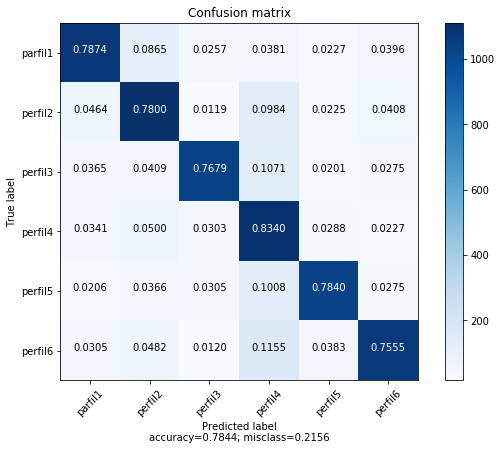

In [ ]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['parfil1', 'perfil2', 'perfil3', 'perfil4', 'perfil5', 'perfil6'])

## Criando um modelo XBoost

In [ ]:
xg_boost = XGBClassifier()

xg_boost.fit(X_train, y_train)

y_pred = xg_boost.predict(X_test)

print("Acurácia: {}%".format(100*round(accuracy_score(y_test, y_pred), 2)))

Acurácia: 78.0%


In [ ]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     perfil1       0.83      0.79      0.81      1364
     perfil2       0.76      0.80      0.78      1423
     perfil3       0.92      0.74      0.82      1344
     perfil4       0.64      0.82      0.72      1319
     perfil5       0.87      0.77      0.82      1310
     perfil6       0.76      0.78      0.77      1411

    accuracy                           0.78      8171
   macro avg       0.80      0.78      0.79      8171
weighted avg       0.80      0.78      0.79      8171



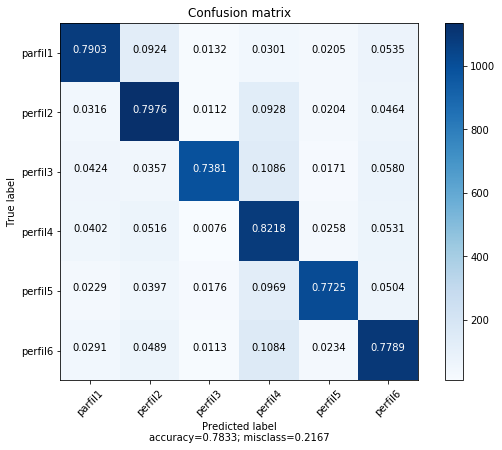

In [ ]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['parfil1', 'perfil2', 'perfil3', 'perfil4', 'perfil5', 'perfil6'])

## Criando um modelo Naive Bayes

In [ ]:
gnv = GaussianNB()

gnv.fit(X_train, y_train)

y_pred = gnv.predict(X_test)

print("Acurácia: {}%".format(100*round(accuracy_score(y_test, y_pred), 2)))

Acurácia: 46.0%


In [ ]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     perfil1       0.84      0.76      0.79      1364
     perfil2       0.69      0.53      0.60      1423
     perfil3       0.40      0.57      0.47      1344
     perfil4       0.27      0.09      0.13      1319
     perfil5       0.24      0.37      0.29      1310
     perfil6       0.43      0.46      0.44      1411

    accuracy                           0.46      8171
   macro avg       0.48      0.46      0.46      8171
weighted avg       0.48      0.46      0.46      8171



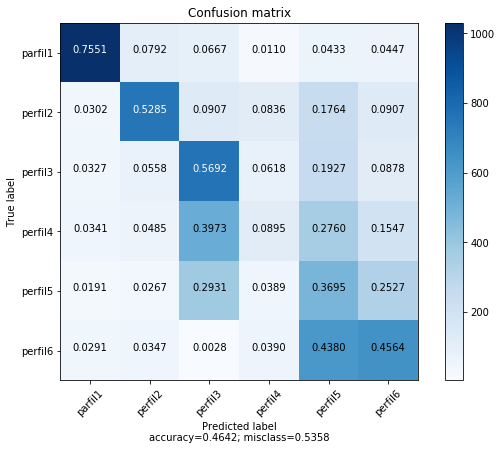

In [ ]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['parfil1', 'perfil2', 'perfil3', 'perfil4', 'perfil5', 'perfil6'])

## Criando um modelo KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print("Acurácia: {}%".format(100*round(accuracy_score(y_test, y_pred), 2)))

Acurácia: 72.0%


In [ ]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     perfil1       0.61      0.72      0.66      1364
     perfil2       0.65      0.56      0.60      1423
     perfil3       0.78      0.84      0.81      1344
     perfil4       0.73      0.79      0.76      1319
     perfil5       0.80      0.79      0.80      1310
     perfil6       0.80      0.66      0.72      1411

    accuracy                           0.72      8171
   macro avg       0.73      0.73      0.72      8171
weighted avg       0.73      0.72      0.72      8171



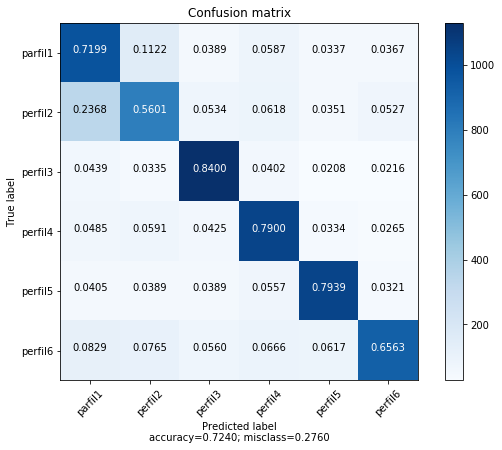

In [ ]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), ['parfil1', 'perfil2', 'perfil3', 'perfil4', 'perfil5', 'perfil6'])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools


def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

<hr>

## Scoring dos dados necessários para entregar a solução

Como entrega da sua solução, esperamos os resultados classificados no seguinte dataset chamado "to_be_scored.csv":

### Download da "folha de respostas"

In [ ]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/dataset-3/master/to_be_scored.csv
df_to_be_scored = pd.read_csv(r'to_be_scored.csv')
df_to_be_scored.tail()

--2020-09-04 19:31:37--  https://raw.githubusercontent.com/vanderlei-test/dataset-3/master/to_be_scored.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96291 (94K) [text/plain]
Saving to: ‘to_be_scored.csv’

100%[======================================>] 96,291      --.-K/s   in 0.006s  

2020-09-04 19:31:37 (16.6 MB/s) - ‘to_be_scored.csv’ saved [96291/96291]



,id,graduacao,universidade,profissao,organizacao,pretende_fazer_cursos_lit,interesse_mba_lit,importante_ter_certificado,horas_semanais_estudo,como_conheceu_lit,total_modulos,modulos_iniciados,modulos_finalizados,certificados
995,741745189,SEM FORMAÇÃO,UNIVERSIDADE NOVE DE JULHO,Coordenador,Borracha,0,0,1,2,YouTube,245,63,45,1
996,996387882,Bacharelado,UFRN,Assessor,Estado,1,1,1,8,Google,163,111,96,0
997,668869418,Bacharelado,UFSCar,Gerente,Siderurgica,1,1,1,9,Facebook,56,10,4,0
998,676531718,Tecnólogo,FATEC,Outros,servicos,1,1,1,9,Mídia (revista/jornal/web),138,60,30,0
999,388402340,Especialização,UNIP,Advogado,Montadora,0,0,1,9,Mídia (revista/jornal/web),22,20,19,0


# Atenção!

O dataframe ``to_be_scored`` é a sua "folha de respostas". Note que a coluna "categoria" não existe nessa amostra, que não pode ser então utilizada para treino de modelos de aprendizado supervisionado.

In [ ]:
df_to_be_scored.info()

<hr>

# Atenção!

# Para poder aplicar seu modelo e classificar a folha de respostas, você precisa primeiro aplicar as mesmas transformações com colunas que você aplicou no dataset de treino.

# Não remova ou adicione linhas na folha de respostas. 

# Não altere a ordem das linhas na folha de respostas.

# Ao final, as 1000 entradas devem estar classificadas, com os valores previstos em uma coluna chamada "target"

<hr>

Na célula abaixo, repetimos rapidamente os mesmos passos de pré-processamento usados no exemplo dado com árvore de decisão

In [ ]:
# 1 - Removendo as colunas que não serão utilizadas no modelo.
df_to_be_scored_1 = df_to_be_scored.drop(columns=['id', 'universidade', 'organizacao', 'profissao', 'pretende_fazer_cursos_lit', 'importante_ter_certificado', 'como_conheceu_lit', 'interesse_mba_lit', 'modulos_iniciados'])

# 2 - Aplica o valor 'Nao Especificado' a todas as linhas da coluna 'Graduacao' com missing values (null).
s_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='Nao Especificado', verbose=0, copy=True)
# Define a coluna 'graduacao' como dataset
s_imputer.fit(X=df_to_be_scored_1[["graduacao"]])
#aplica o simple imputer transform
df_to_be_scored_1["graduacao"] = s_imputer.transform(X=df_to_be_scored_1[["graduacao"]])

# 3 - Para os valores missing values da coluna Certificados será atribuido o valor 0.
s_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0, verbose=0, copy=True)
# Define a coluna 'certificados' como dataset
s_imputer.fit(X=df_to_be_scored_1[["certificados"]])
#aplica o simple imputer transform
df_to_be_scored_1["certificados"] = s_imputer.transform(X=df_to_be_scored_1[["certificados"]])

# 4 - Transformação da coluna Certificados em binária (0 - não tem certificado e 1 - tem 1 ou mais certificado)
df_to_be_scored_1["certificados"] = df_to_be_scored_1["certificados"].apply(lambda x: 1 if x > 0 else x)

# 5 - Atualiza os missing values da coluna horas_semanais_estudo c/ a mediana.
s_imputer = SimpleImputer(missing_values=np.nan, strategy='median', verbose=0, copy=True)
# Define a coluna 'horas_semanais_estudo' como dataset
s_imputer.fit(X=df_to_be_scored_1[["horas_semanais_estudo"]])
#aplica o simple imputer transform
df_to_be_scored_1["horas_semanais_estudo"] = s_imputer.transform(X=df_to_be_scored_1[["horas_semanais_estudo"]])

# 6 - Atualiza os missing values da coluna total_modulos c/ a mediana.
s_imputer = SimpleImputer(missing_values=np.nan, strategy='median', verbose=0, copy=True)
# Define a coluna 'total_modulos' como dataset
s_imputer.fit(X=df_to_be_scored_1[["total_modulos"]])
#aplica o simple imputer transform
df_to_be_scored_1["total_modulos"] = s_imputer.transform(X=df_to_be_scored_1[["total_modulos"]])

# 7 - Atualiza os missing values da coluna modulos_finalizados c/ a mediana.
s_imputer = SimpleImputer(missing_values=np.nan, strategy='median', verbose=0, copy=True)
# Define a coluna 'modulos_finalizados' como dataset
s_imputer.fit(X=df_to_be_scored_1[["modulos_finalizados"]])
#aplica o simple imputer transform
df_to_be_scored_1["modulos_finalizados"] = s_imputer.transform(X=df_to_be_scored_1[["modulos_finalizados"]])

# 8 - Ajuste dos outliers das colunas "modulos_finalizados" e "total_modulos"
outliers = HandleOutliers(columns=["modulos_finalizados", "total_modulos"])
# Aplicando a transformação ``HandleOutliers`` ao conjunto de dados base
outliers.fit(X=df_to_be_scored_1)
# Reconstruindo um DataFrame Pandas com o resultado da transformação
df_to_be_scored_2 = pd.DataFrame.from_records(data=outliers.transform(X=df_to_be_scored_1),)

# 4 - Encoding com "dummy variables"
df_to_be_scored_3 = pd.get_dummies(df_to_be_scored_2, columns=['graduacao'])

df_to_be_scored_3.tail()

<hr>

Pode ser verificado abaixo que as colunas da folha de resposta agora são idênticas às que foram usadas para treinar o modelo:

In [ ]:
df_training[
    [
        'pretende_fazer_cursos_lit', 'interesse_mba_lit',
        'importante_ter_certificado', 'horas_semanais_estudo', 'total_modulos',
        'modulos_iniciados', 'modulos_finalizados', 'certificados',
        'profissao_0', 'profissao_Advogado', 'profissao_Analista',
        'profissao_Analista Senior', 'profissao_Assessor',
        'profissao_Coordenador', 'profissao_Diretor', 'profissao_Engenheiro',
        'profissao_Gerente', 'profissao_Outros', 'profissao_SEM EXPERIÊNCIA',
        'profissao_Supervisor', 'profissao_Sócio/Dono/Proprietário'
    ]
].columns

features = df_training[
    [
        'horas_semanais_estudo', 'total_modulos', 'modulos_finalizados',
       'certificados', 'graduacao_Bacharelado',
       'graduacao_Especialização', 'graduacao_Licenciatura', 'graduacao_MBA',
       'graduacao_Nao Especificado', 'graduacao_SEM FORMAÇÃO',
       'graduacao_Tecnólogo'
    ]
]

In [ ]:
df_to_be_scored_3.columns

# Atenção

Para todas colunas que não existirem no "df_to_be_scored", você pode usar a técnica abaixo para adicioná-las:

In [ ]:
df_to_be_scored_3['graduacao_Nao Especificado'] = 0

In [ ]:
y_pred = dtc.predict(df_to_be_scored_3)
df_to_be_scored_3['target'] = y_pred
df_to_be_scored_3.tail()

### Salvando a folha de respostas como um arquivo .csv para ser submetido

In [ ]:
project.save_data(file_name="results.csv", data=df_to_be_scored_3.to_csv(index=False))

# Atenção

# A execução da célula acima irá criar um novo "data asset" no seu projeto no Watson Studio. Você precisará realizar o download deste arquivo juntamente com este notebook e criar um arquivo zip com os arquivos **results.csv** e **notebook.ipynb** para submissão. (os arquivos devem estar nomeados desta forma)

<hr>

## Parabéns!

Se você já está satisfeito com a sua solução, vá até a página abaixo e envie os arquivos necessários para submissão.

# https://lit.maratona.dev
